In [94]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VISNN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
import gc
gc.enable
import pandas as pd
pd.options.mode.chained_assignment=None
import numpy as np
import re
import spacy
import string
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer

sns.set(rc={'figure.figsize':(15, 16)})
print(sns.__version__)

0.10.1


In [96]:
data = pd.read_csv('blogtext.csv',nrows=50000,index_col=False)

In [97]:
data

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
...,...,...,...,...,...,...,...
49995,1273538,male,23,Advertising,Taurus,"13,August,2003",Aug 7th Thur... Bought Her Mua Chee & S...
49996,1273538,male,23,Advertising,Taurus,"13,August,2003",Aug 6th Wed.. Her 1st Day @ Work Back @...
49997,1273538,male,23,Advertising,Taurus,"13,August,2003",Aug 4th Mon Zing's BD !! Went To Her Pl...
49998,1273538,male,23,Advertising,Taurus,"13,August,2003",Aug 3rd Sun.. Went To Her Place B4 Goin...


In [98]:
data=data.drop(['id','date'],axis=1)

In [99]:
type(data)

pandas.core.frame.DataFrame

In [100]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  50000 non-null  object
 1   age     50000 non-null  int64 
 2   topic   50000 non-null  object
 3   sign    50000 non-null  object
 4   text    50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [101]:
# Let us randomize the data a little bit:
data = data.sample(frac=1).reset_index(drop=True)

# Preprocessing

Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.

In [102]:
df= data[['text']]

In [103]:
df[:5]

,text
0,i posted again
1,happy valentines day!!!!!! man its...
2,Several months ago I was o...
3,i just found out sumthing that ruined ...
4,So let's see...what's up for ...


In [104]:
pd.options.mode.chained_assignment = None
df['text'] = df[['text']]
df["text"] = df["text"].astype(str)

Lower Casing:
Lower casing a common pre-processing techniques. The idea is to convert the input text in to same casing format so the 'text' , 'Text' and TEXT are treated the same way.

This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplicaiton and get correct counts/tfidf vlaues.

This may not be helpful when we do tasks like Part of Speech tagging or sentiment analysis where upper casing refers to ANGER and so on.

BY default, lower casing is done by most of the modern vectorizers and tokenizers . SO we need to set them to FLASE as depending upon our cases

In [105]:
# Converting to Lower Case
df["text_lower"]=df["text"].str.lower()
df.head()

,text,text_lower
0,i posted again,i posted again
1,happy valentines day!!!!!! man its...,happy valentines day!!!!!! man its...
2,Several months ago I was o...,several months ago i was o...
3,i just found out sumthing that ruined ...,i just found out sumthing that ruined ...
4,So let's see...what's up for ...,so let's see...what's up for ...


Removal of Punctuations
One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardizations process that will help to treat 'hurray' and 'hurray!' in the same way.

We also need to carefully choose the list of punctuations to exclude depending on the use case. FOr example, the string.punctuation in python contains the folowing symbols:

!"#$%&\'()*+,-./:;<=>?@[\]^_{|}~`

This list is customizable

In [106]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('','',PUNCT_TO_REMOVE))
                                        
df["text_wo_punctuation"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

,text,text_lower,text_wo_punctuation
0,i posted again,i posted again,i posted again
1,happy valentines day!!!!!! man its...,happy valentines day!!!!!! man its...,happy valentines day man its like ...
2,Several months ago I was o...,several months ago i was o...,several months ago i was o...
3,i just found out sumthing that ruined ...,i just found out sumthing that ruined ...,i just found out sumthing that ruined ...
4,So let's see...what's up for ...,so let's see...what's up for ...,so lets seewhats up for today...


Removal of StopWords
Stopwords are commonly occuring words in a language like 'the' 'a' and so on. They can be removed from the text most of the times as they dont provide valuable informaiton for furtherstage analysis. Incases like POS tagging, we should not remove them as provide very valauble information about the POS.

These stopword lists are already compiled for different languages and we can safely use them. For Eg:- the stopword list for english language from the NLTK package can be seen below:

In [107]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [108]:
STOPWORDS = set (stopwords.words('english'))

def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])
                                        
df["text_wo_stop"] = df["text_wo_punctuation"].apply(lambda text : remove_stopwords(text))
df.head()

,text,text_lower,text_wo_punctuation,text_wo_stop
0,i posted again,i posted again,i posted again,posted
1,happy valentines day!!!!!! man its...,happy valentines day!!!!!! man its...,happy valentines day man its like ...,happy valentines day man like 330 still long d...
2,Several months ago I was o...,several months ago i was o...,several months ago i was o...,several months ago occupying time ana website ...
3,i just found out sumthing that ruined ...,i just found out sumthing that ruined ...,i just found out sumthing that ruined ...,found sumthing ruined mi day thats great isnt ...
4,So let's see...what's up for ...,so let's see...what's up for ...,so lets seewhats up for today...,lets seewhats today got came work work related...


Exploratory data analysis

In [109]:
data.head()

,gender,age,topic,sign,text
0,male,35,Technology,Aries,i posted again
1,female,23,Engineering,Libra,happy valentines day!!!!!! man its...
2,female,23,Education,Pisces,Several months ago I was o...
3,female,14,Student,Aquarius,i just found out sumthing that ruined ...
4,female,23,Engineering,Cancer,So let's see...what's up for ...


In [110]:
pd.set_option('display.max_colwidth', 50)
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
gender,male,female,female,female,female,male,female,female,female,male
age,35,23,23,14,23,17,24,24,25,24
topic,Technology,Engineering,Education,Student,Engineering,Arts,Communications-Media,indUnk,Technology,Student
sign,Aries,Libra,Pisces,Aquarius,Cancer,Pisces,Aquarius,Aries,Sagittarius,Taurus
text,i posted again,happy valentines day!!!!!! man its...,Several months ago I was o...,i just found out sumthing that ruined ...,So let's see...what's up for ...,Even Pilz-e doesn't have this much s...,Yesterday on the way home from wo...,&emailalert=no&email=adgrant@indiana.e...,"After a gap of two days, I thought this...",Glenn : So this is the first post by ...


In [111]:
data.isnull().any().any() 
# No MIssing values

False

In [112]:
data.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
age,50000.0,24.36214,7.982836,13.0,17.0,24.0,27.0,48.0


In [113]:
print(data.age.value_counts())

17    6859
24    5746
23    5518
16    4156
27    4094
15    3508
35    3365
26    2869
25    2837
14    2043
36    1985
34    1886
33    1654
13     745
39     412
41     394
46     330
48     318
37     310
47     206
38     196
40     192
43     150
42      96
45      93
44      38
Name: age, dtype: int64


In [114]:
data.describe(include = [np.object]).T

,count,unique,top,freq
gender,50000,2,male,25815
topic,50000,40,indUnk,17560
sign,50000,12,Aries,7795
text,50000,49249,urlLink,48


In [115]:
data.gender.value_counts()

male      25815
female    24185
Name: gender, dtype: int64

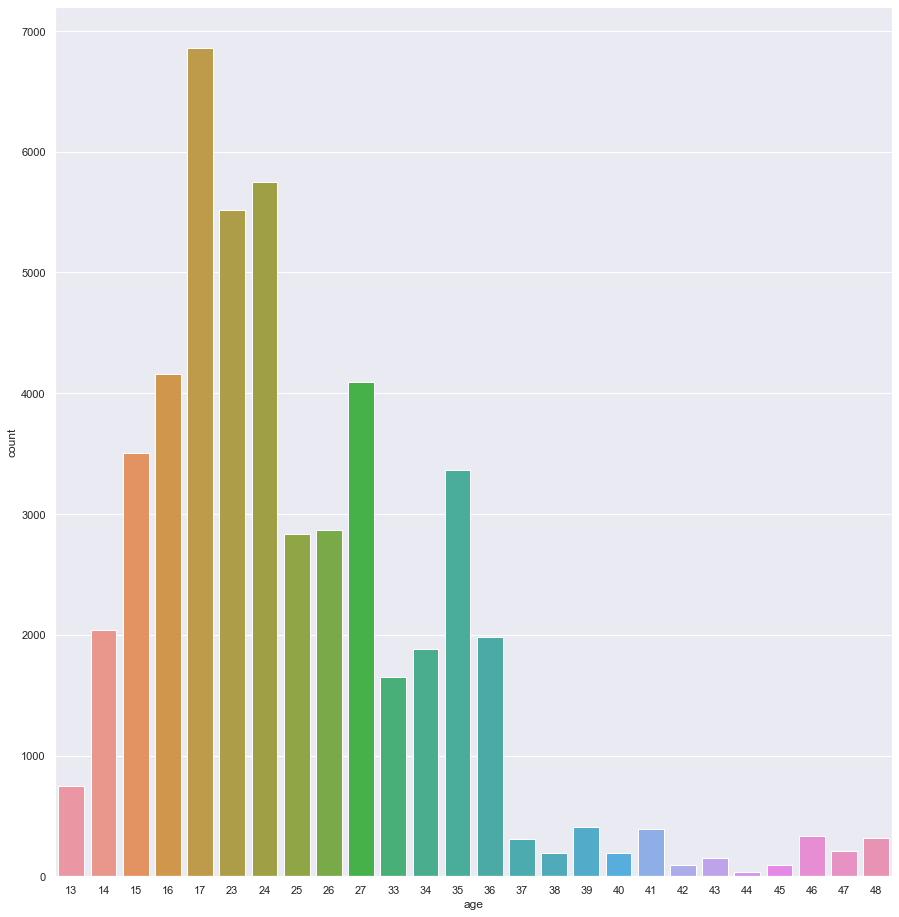

In [116]:
sns.countplot(x="age", data=data)

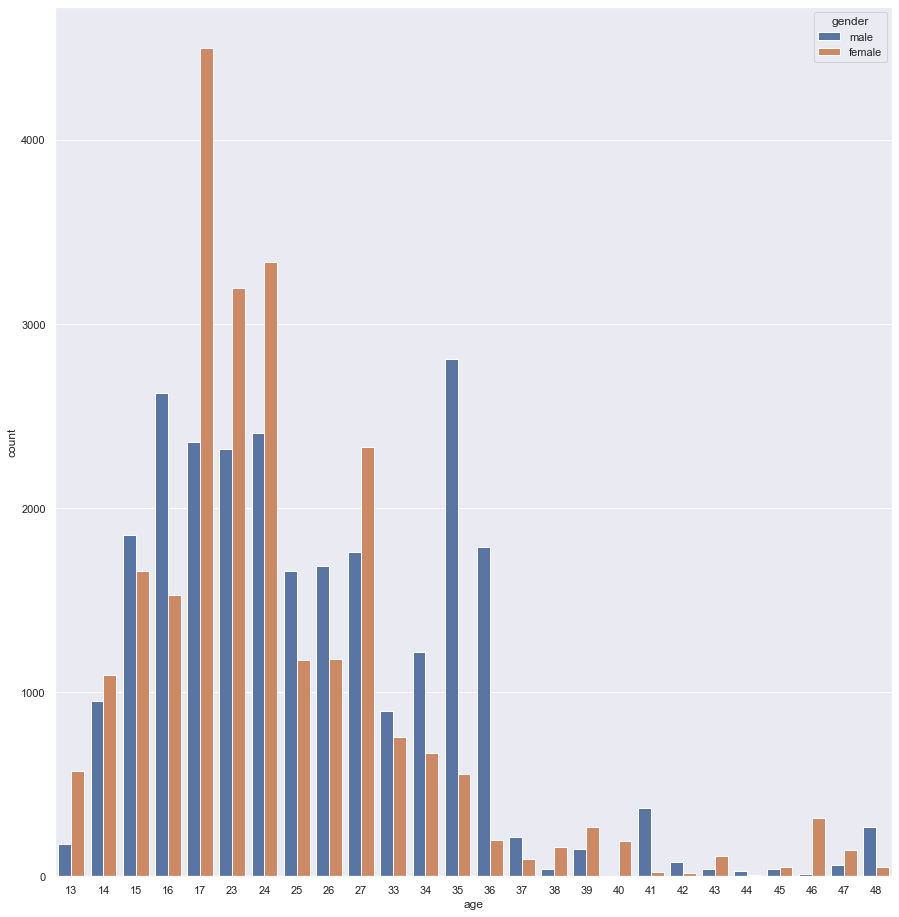

In [117]:
sns.countplot(x="age", hue="gender", data=data)

In [118]:
# Merge the labels for multi-label classificaiton problem

In [119]:
data["age"]= data["age"].astype(str)
data["labels"] = data.apply(lambda col :
                            [col["gender"],col["age"],col["topic"],col["sign"]],axis =1)

In [120]:
data.drop(columns=["gender","age","sign","topic"],axis =1,inplace=True)
gc.collect()

136

In [121]:
data.head(10)

,text,labels
0,i posted again,"[male, 35, Technology, Aries]"
1,happy valentines day!!!!!! man its...,"[female, 23, Engineering, Libra]"
2,Several months ago I was o...,"[female, 23, Education, Pisces]"
3,i just found out sumthing that ruined ...,"[female, 14, Student, Aquarius]"
4,So let's see...what's up for ...,"[female, 23, Engineering, Cancer]"
5,Even Pilz-e doesn't have this much s...,"[male, 17, Arts, Pisces]"
6,Yesterday on the way home from wo...,"[female, 24, Communications-Media, Aquarius]"
7,&emailalert=no&email=adgrant@indiana.e...,"[female, 24, indUnk, Aries]"
8,"After a gap of two days, I thought this...","[female, 25, Technology, Sagittarius]"
9,Glenn : So this is the first post by ...,"[male, 24, Student, Taurus]"


In [122]:
# Creating a test and train dataset
from sklearn.model_selection import train_test_split
X= data.text
y= data.labels

X_train, X_test, y_train,y_test = train_test_split(X,y, random_state=42,test_size=0.1,shuffle=True)

In [123]:
X_train.shape

(45000,)

In [124]:
X_test.shape

(5000,)

In [125]:
# we need to conver the text in to some for m of numerical features or vector mode
# in order to perform operaitons on them

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [126]:
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                      ngram_range=(1, 3), stop_words = 'english')

In [127]:
corpus = list(X_train) +list(X_test)

In [128]:
ctv.fit(corpus)

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [129]:
X_train_ctv = ctv.transform(X_train)

In [130]:
X_train_ctv

<45000x7282713 sparse matrix of type '<class 'numpy.int64'>'
	with 11825634 stored elements in Compressed Sparse Row format>

In [131]:
X_test_ctv = ctv.transform(X_test)

In [132]:
# Creating a dictionary and getting the count of very label

In [133]:
# the key will be a label name and the value will be the total count of the label.

label_counts=dict()

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
            
label_counts

{'male': 25815,
 '35': 3365,
 'Technology': 4379,
 'Aries': 7795,
 'female': 24185,
 '23': 5518,
 'Engineering': 1402,
 'Libra': 4378,
 'Education': 2646,
 'Pisces': 4142,
 '14': 2043,
 'Student': 10660,
 'Aquarius': 4784,
 'Cancer': 4589,
 '17': 6859,
 'Arts': 1817,
 '24': 5746,
 'Communications-Media': 1603,
 'indUnk': 17560,
 '25': 2837,
 'Sagittarius': 4571,
 'Taurus': 3390,
 '41': 394,
 'BusinessServices': 416,
 'Non-Profit': 491,
 '15': 3508,
 'Scorpio': 3243,
 '33': 1654,
 'InvestmentBanking': 85,
 '16': 4156,
 'Capricorn': 3819,
 '34': 1886,
 'Gemini': 2558,
 '27': 4094,
 '37': 310,
 'Virgo': 2827,
 '26': 2869,
 'Government': 599,
 '36': 1985,
 'Fashion': 1805,
 'Science': 705,
 'Leo': 3904,
 'Internet': 1420,
 '39': 412,
 '13': 745,
 'Advertising': 273,
 'Manufacturing': 441,
 'Automotive': 116,
 'Architecture': 70,
 'Law': 308,
 '47': 206,
 'Sports-Recreation': 120,
 'Religion': 258,
 'Transportation': 196,
 '44': 38,
 '40': 192,
 'Consulting': 243,
 'Military': 194,
 '42': 9

Transfrom the labels
Transform between iterable of iterables and a multilabel format

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform the labelsin a binary form and the prediction will be a mask of 0s and 1s. FOr this purpose, it is convenient to use multilabel binarizer fom sklearn.
Convert your train and test labels using Multilabel Binarizer.


In [134]:
from sklearn.preprocessing import MultiLabelBinarizer

#Transform between iterable of iterables and a multilabel format
binarizer = MultiLabelBinarizer(classes=sorted(label_counts.keys()))

y_train= binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [135]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [138]:
binarizer.inverse_transform(y_train)

[('34', 'Sagittarius', 'female', 'indUnk'),
 ('35', 'Aries', 'Technology', 'male'),
 ('15', 'Student', 'Virgo', 'male'),
 ('35', 'Cancer', 'Technology', 'male'),
 ('24', 'Aries', 'female', 'indUnk'),
 ('37', 'Aries', 'Education', 'female'),
 ('25', 'Taurus', 'female', 'indUnk'),
 ('17', 'Communications-Media', 'Libra', 'male'),
 ('33', 'Internet', 'Taurus', 'female'),
 ('23', 'Scorpio', 'Student', 'female'),
 ('17', 'Leo', 'indUnk', 'male'),
 ('40', 'Virgo', 'female', 'indUnk'),
 ('36', 'Aries', 'Fashion', 'male'),
 ('24', 'Aries', 'indUnk', 'male'),
 ('14', 'Pisces', 'Student', 'male'),
 ('24', 'Aries', 'indUnk', 'male'),
 ('25', 'Sagittarius', 'Science', 'male'),
 ('27', 'Gemini', 'female', 'indUnk'),
 ('17', 'Capricorn', 'Student', 'female'),
 ('35', 'Libra', 'female', 'indUnk'),
 ('24', 'Libra', 'Student', 'male'),
 ('24', 'Sagittarius', 'female', 'indUnk'),
 ('35', 'Aries', 'Technology', 'male'),
 ('23', 'Pisces', 'Student', 'female'),
 ('27', 'Pisces', 'Technology', 'male'),
 ('2

 MutliLabel Classificaiton Techniques
Most traditional learning algorithms are developed for single- label classifications problems.
Therefore a lot of approached in the literature transform the mutlilabel problem in to multiple single-label problems, so that the exisiting single - label algorithms can be used.


 Accuracy Metric
 
 Before diving in to preparing models, let's settle with metrics to measure prediction score:
 
 1.) Accuracy Score
 2.) F1 Score
 3.) Average precision score : 
        3.1 Macro averaged precision: calculate precision for all classes
            individually and then average them
        3.2 Micro averaged precision: calculate class wise true positive and false
            positive and then use that to calculate overall precision
  4.) Average recall score
 

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

OnevsRest

Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).

In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.

The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'),
                    n_jobs=-1)),])
LogReg_pipeline.fit(X_train_ctv, y_train)

Y_predicted_oneVsRest = LogReg_pipeline.predict(X_test_ctv)

In [44]:
display_metrics_micro(y_test,Y_predicted_oneVsRest)

Accuracy score:  0.0168
F1 score: Micro 0.3000806668459263
Average precision score: Micro 0.16667985330681254
Average recall score: Micro 0.1953


In [45]:
display_metrics_macro(y_test,Y_predicted_oneVsRest)

Accuracy score:  0.0168
F1 score: Macro 0.04099680320733488
Average recall score: MAcro 0.030366730840489742


C:\Users\VISNN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\VISNN\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
identifier= [2 , 3,4000,500,4500,345,478]
for i in identifier:             
    print (" The prediction is ", binarizer.inverse_transform(Y_predicted_oneVsRest)[i])
    print (" The actual is ",binarizer.inverse_transform(y_test)[i])

 The prediction is  ('Student', 'female')
 The actual is  ('15', 'Cancer', 'Student', 'female')
 The prediction is  ('male',)
 The actual is  ('27', 'Pisces', 'Technology', 'male')
 The prediction is  ('male',)
 The actual is  ('36', 'Aries', 'Fashion', 'male')
 The prediction is  ('male',)
 The actual is  ('17', 'Sagittarius', 'Student', 'male')
 The prediction is  ('male',)
 The actual is  ('17', 'Aquarius', 'Student', 'female')
 The prediction is  ('female', 'indUnk')
 The actual is  ('14', 'Student', 'Virgo', 'female')
 The prediction is  ('23', 'Engineering', 'Libra', 'female')
 The actual is  ('23', 'Engineering', 'Libra', 'female')


# Part -2 Chatbot

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.optimizers import SGD
import random

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
nltk.download('punkt')

intents_file=open('GL Bot.json').read()
intents = json.loads(intents_file)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VISNN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [8]:
intents

{'intents': [{'tag': 'Intro',
   'patterns': ['hi',
    'how are you',
    'is anyone there',
    'hello',
    'whats up',
    'hey',
    'yo',
    'listen',
    'please help me',
    'i am learner from',
    'i belong to',
    'aiml batch',
    'aifl batch',
    'i am from',
    'my pm is',
    'blended',
    'online',
    'i am from',
    'hey ya',
    'talking to you for first time'],
   'responses': ['Hello! how can i help you ?'],
   'context_set': ''},
  {'tag': 'Exit',
   'patterns': ['thank you',
    'thanks',
    'cya',
    'see you',
    'later',
    'see you later',
    'goodbye',
    'i am leaving',
    'have a Good day',
    'you helped me',
    'thanks a lot',
    'thanks a ton',
    'you are the best',
    'great help',
    'too good',
    'you are a good learning buddy'],
   'responses': ['I hope I was able to assist you, Good Bye'],
   'context_set': ''},
  {'tag': 'Olympus',
   'patterns': ['olympus',
    'explain me how olympus works',
    'I am not able to understan

Step:-2 Preprocessing the Data

The model cannot take the raw data. It has to go through a lot of pre-processing for the machine to easiliy understand. FOr textual data,there are many preprocessing techniques. The first one is tokenizing inwhich the sentences are broken in tokens or words.

By observing the intents file, we can see that each tag contains a list of patterns and responses. We tokenize each pattern and add the words in a list. Also we create a list of classes and documents to add al the intents associated with patterns.

In [24]:
words=[]
classes=[]
documents=[]
ignore_letters=['!','?',',','.']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        #Tokenize each word
        word = nltk.word_tokenize(pattern)
        words.extend(word)
        # add the documents in the corpus:
        documents.append((word,intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])
            
print(documents)


[(['hi'], 'Intro'), (['how', 'are', 'you'], 'Intro'), (['is', 'anyone', 'there'], 'Intro'), (['hello'], 'Intro'), (['whats', 'up'], 'Intro'), (['hey'], 'Intro'), (['yo'], 'Intro'), (['listen'], 'Intro'), (['please', 'help', 'me'], 'Intro'), (['i', 'am', 'learner', 'from'], 'Intro'), (['i', 'belong', 'to'], 'Intro'), (['aiml', 'batch'], 'Intro'), (['aifl', 'batch'], 'Intro'), (['i', 'am', 'from'], 'Intro'), (['my', 'pm', 'is'], 'Intro'), (['blended'], 'Intro'), (['online'], 'Intro'), (['i', 'am', 'from'], 'Intro'), (['hey', 'ya'], 'Intro'), (['talking', 'to', 'you', 'for', 'first', 'time'], 'Intro'), (['thank', 'you'], 'Exit'), (['thanks'], 'Exit'), (['cya'], 'Exit'), (['see', 'you'], 'Exit'), (['later'], 'Exit'), (['see', 'you', 'later'], 'Exit'), (['goodbye'], 'Exit'), (['i', 'am', 'leaving'], 'Exit'), (['have', 'a', 'Good', 'day'], 'Exit'), (['you', 'helped', 'me'], 'Exit'), (['thanks', 'a', 'lot'], 'Exit'), (['thanks', 'a', 'ton'], 'Exit'), (['you', 'are', 'the', 'best'], 'Exit'), (

#Lemmatization- Extracting the roots or Lemma



In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VISNN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [143]:
# Lemmatize and lower each word and remove duplicates

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))
# sort classes:
classes = sorted(list(set(classes)))
#documents = combination b/w patterns and intents
print(len(documents),"documents")
#classes= intents
print(len(classes),"classes",classes)
#words = all waords, vocabulary
print(len(words),"unique lemmatized words", words)

pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

128 documents
8 classes ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
158 unique lemmatized words ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation', 'opertions', 'otimi

Step:-3 Create Training and Testing Data

To train the model, we will convert each input pattern in to numbers. First, we will lemmatize each word of the pattern and create list of zeroes of the same length as the total number of words. We will set value 1 to only those indexes that contain the word in the patterns. I the same way we will create the output by setting 1 to the class input the pattern belong to.

In [145]:
# Create the training data:
training=[]
#create empty array for the output
output_empty=[0]*len(classes)
# training set, bag of words for evry sentence
for doc in documents:
    #initializing the bag of words
    bag =[]
    #list of tokenized words for the pattern
    word_patterns = doc[0]
    #words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
    #words = sorted(list(set(words)))
    
    #lemmatize each word - create base word, in attempt to represent related words
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
   
    # create the bag of words array with 1, if word is found in current pattern
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
    
#shuffle the features and make numpy array
random.shuffle(training)
training=np.array(training)
#create training and testing lists. X- patterns, Y-intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data is created")

Training data is created


<ipython-input-145-356882a2a0a7>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  training=np.array(training)


Step 4: Training the model

The architecture of our model will be a neural network consisting of 3 dense layers. The first layer has 128 neurons, the second one has 64 and last layer will have the same neurons as the number of classes. 
The dropput layers are introduced to reduce overfitting of the model. We have used the SGD optimizer and fit the data to start the training of the model. After the training of 200 epochs is completed, we then save trained model using the keras model.save("chatbot_model.h5") function.



In [146]:
# deep neural networds model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compiling model. SGD with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#Training and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)
print("model is created")

Epoch 1/200
26/26 [==============================] - 1s 920us/step - loss: 2.0945 - accuracy: 0.1438
Epoch 2/200
26/26 [==============================] - 0s 840us/step - loss: 1.9846 - accuracy: 0.2583
Epoch 3/200
26/26 [==============================] - 0s 840us/step - loss: 1.9390 - accuracy: 0.2204
Epoch 4/200
26/26 [==============================] - 0s 880us/step - loss: 1.8310 - accuracy: 0.2966
Epoch 5/200
26/26 [==============================] - 0s 960us/step - loss: 1.7389 - accuracy: 0.4033
Epoch 6/200
26/26 [==============================] - 0s 720us/step - loss: 1.5956 - accuracy: 0.4214
Epoch 7/200
26/26 [==============================] - 0s 800us/step - loss: 1.5947 - accuracy: 0.4289
Epoch 8/200
26/26 [==============================] - 0s 760us/step - loss: 1.3631 - accuracy: 0.5259
Epoch 9/200
26/26 [==============================] - 0s 720us/step - loss: 1.1692 - accuracy: 0.6179
Epoch 10/200
26/26 [==============================] - 0s 760us/step - loss: 1.0903 - accura

26/26 [==============================] - 0s 762us/step - loss: 0.0211 - accuracy: 0.9957
Epoch 82/200
26/26 [==============================] - 0s 880us/step - loss: 0.0468 - accuracy: 0.9856
Epoch 83/200
26/26 [==============================] - 0s 960us/step - loss: 0.0579 - accuracy: 0.9712
Epoch 84/200
26/26 [==============================] - 0s 920us/step - loss: 0.0261 - accuracy: 0.9912
Epoch 85/200
26/26 [==============================] - 0s 720us/step - loss: 0.0698 - accuracy: 0.9658
Epoch 86/200
26/26 [==============================] - 0s 800us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 87/200
26/26 [==============================] - 0s 640us/step - loss: 0.0589 - accuracy: 0.9598
Epoch 88/200
26/26 [==============================] - 0s 640us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 89/200
26/26 [==============================] - 0s 600us/step - loss: 0.0519 - accuracy: 0.9847
Epoch 90/200
26/26 [==============================] - 0s 600us/step - loss: 0.0614 - accuracy: 

26/26 [==============================] - 0s 720us/step - loss: 0.0629 - accuracy: 0.9807
Epoch 161/200
26/26 [==============================] - 0s 716us/step - loss: 0.0481 - accuracy: 0.9771
Epoch 162/200
26/26 [==============================] - 0s 680us/step - loss: 0.0266 - accuracy: 1.0000
Epoch 163/200
26/26 [==============================] - 0s 664us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 164/200
26/26 [==============================] - 0s 671us/step - loss: 0.0135 - accuracy: 0.9988
Epoch 165/200
26/26 [==============================] - 0s 676us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 166/200
26/26 [==============================] - 0s 640us/step - loss: 0.0165 - accuracy: 1.0000
Epoch 167/200
26/26 [==============================] - 0s 676us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 168/200
26/26 [==============================] - 0s 755us/step - loss: 0.0086 - accuracy: 1.0000
Epoch 169/200
26/26 [==============================] - 0s 658us/step - loss: 0.0130 - a

GUI Creation

In [147]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('GL Bot.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))
def clean_up_sentence(sentence):
    # tokenize the pattern - splitting words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stemming every word - reducing to base form
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for words that exist in sentence
def bag_of_words(sentence, words, show_details=True):
    # tokenizing patterns
    sentence_words = clean_up_sentence(sentence)
    # bag of words - vocabulary matrix
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,word in enumerate(words):
            if word == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % word)
    return(np.array(bag))
def predict_class(sentence):
    # filter below  threshold predictions
    p = bag_of_words(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sorting strength probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result
#Creating tkinter GUI
import tkinter
from tkinter import *
def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)
    if msg != '':
        ChatBox.config(state=NORMAL)
        ChatBox.insert(END, "You: " + msg + '\n\n')
        ChatBox.config(foreground="#446665", font=("Verdana", 12 )) 
        ints = predict_class(msg)
        res = getResponse(ints, intents)
        
        ChatBox.insert(END, "Bot: " + res + '\n\n')           
        ChatBox.config(state=DISABLED)
        ChatBox.yview(END)
root = Tk()
root.title("Chatbot")
root.geometry("400x500")
root.resizable(width=FALSE, height=FALSE)
#Create Chat window
ChatBox = Text(root, bd=0, bg="white", height="8", width="50", font="Arial",)
ChatBox.config(state=DISABLED)
#Bind scrollbar to Chat window
scrollbar = Scrollbar(root, command=ChatBox.yview, cursor="heart")
ChatBox['yscrollcommand'] = scrollbar.set
#Create Button to send message
SendButton = Button(root, font=("Verdana",12,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#f9a602", activebackground="#3c9d9b",fg='#000000',
                    command= send )
#Create the box to enter message
EntryBox = Text(root, bd=0, bg="white",width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)
#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatBox.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)
root.mainloop()